This will be our project proposal

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
#tennis 

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Used Variables:

First Column (which we will rename ID_Num),
Height,
Age,
Hand,
Rank,
Ace,
Double Faults (df),
Surface

75% Training 25% Testing

In [3]:
tennis_named <- tennis|>
    rename("ID_num" = 1 )
tennis_smaller <- tennis_named|>
    select(ID_num,winner_hand,winner_ht,winner_age,w_ace, w_df,
                         winner_rank,surface)|>
    mutate(ID_num = as_factor(ID_num), winner_hand = as_factor(winner_hand))
tennis_smaller|>
    slice(1:10)

ID_num,winner_hand,winner_ht,winner_age,w_ace,w_df,winner_rank,surface
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,R,178,29.00479,3,3,9,Hard
1,R,NA,22.88569,10,1,16,Hard
2,R,178,29.00479,2,2,9,Hard
3,R,188,33.70568,12,2,239,Hard
4,R,NA,22.88569,12,3,16,Hard
5,R,188,31.88227,10,8,40,Hard
6,R,178,29.00479,5,2,9,Hard
7,R,188,33.70568,11,3,239,Hard
8,R,NA,19.86858,1,1,31,Hard


In [4]:
tennis_mean <- tennis_smaller|>
    group_by(winner_rank, surface, winner_hand)|>
    summarize(mean_ht = mean(winner_ht, na.rm = TRUE), mean_age = mean(winner_age))
tennis_mean|>
    slice(1:10)

`summarise()` has grouped output by 'winner_rank', 'surface'. You can override
using the `.groups` argument.


winner_rank,surface,winner_hand,mean_ht,mean_age
<dbl>,<chr>,<fct>,<dbl>,<dbl>
1,Clay,R,188.6667,31.31337
1,Clay,L,185.0000,31.91330
1,Grass,R,187.7333,32.84983
1,Grass,L,185.0000,32.07940
1,Hard,R,188.0612,32.04861
1,Hard,L,185.0000,31.98865
2,Clay,R,188.0000,29.97901
2,Clay,L,185.0000,32.72101
2,Grass,R,185.0000,36.86927


In [5]:
tennis_split <- initial_split(tennis_mean, prop = 0.75, strata = winner_rank )
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

In [6]:
tennis_training

winner_rank,surface,winner_hand,mean_ht,mean_age
<dbl>,<chr>,<fct>,<dbl>,<dbl>
1,Clay,R,188.6667,31.31337
1,Clay,L,185.0000,31.91330
1,Grass,R,187.7333,32.84983
1,Grass,L,185.0000,32.07940
1,Hard,R,188.0612,32.04861
2,Clay,L,185.0000,32.72101
2,Grass,L,185.0000,32.32854
2,Hard,R,186.1250,34.37166
3,Clay,R,194.7500,26.38415


Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 194 rows containing missing values (geom_point).”


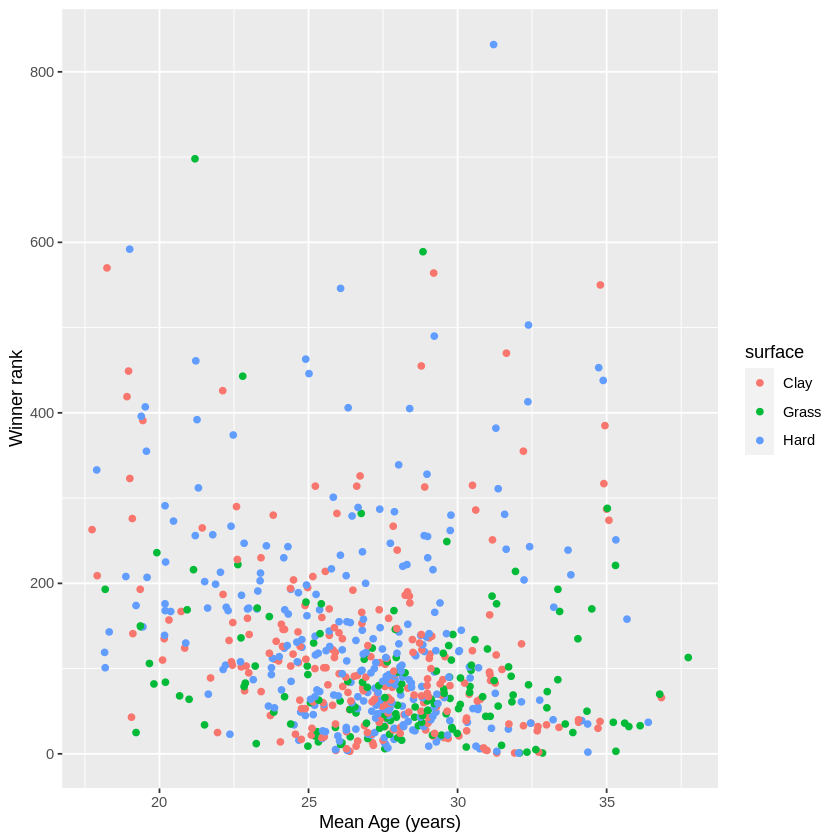

Warning message:
“Removed 1 rows containing missing values (geom_point).”


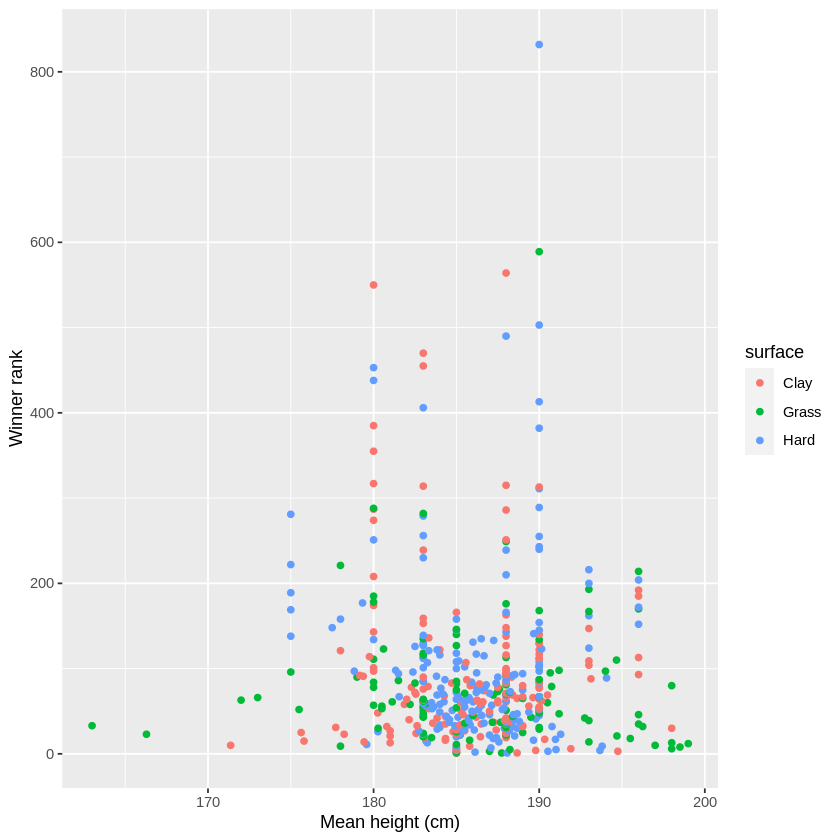

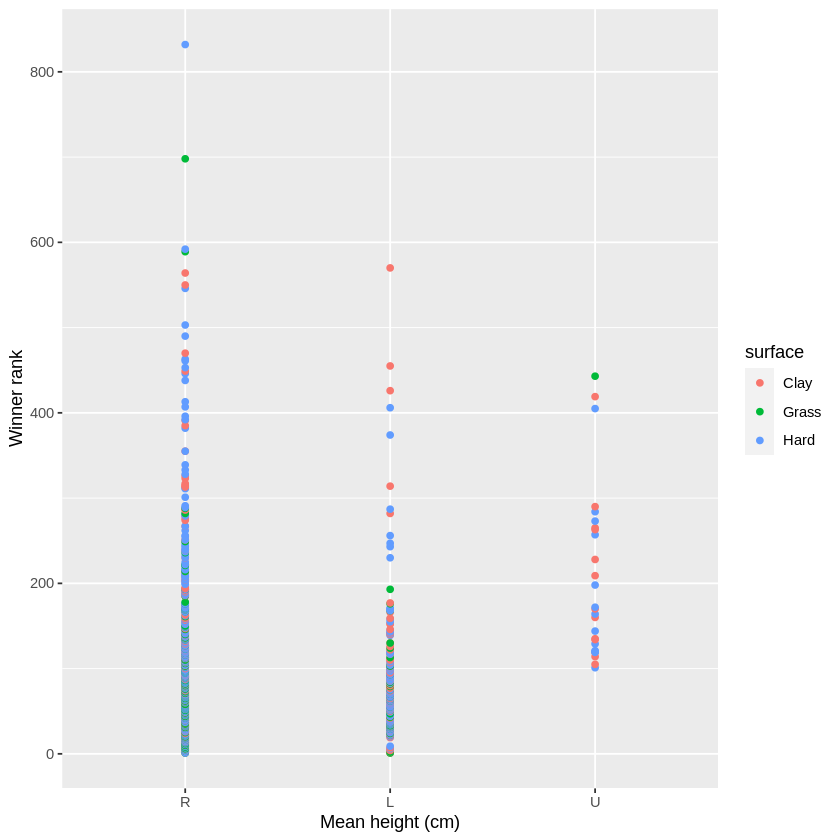

In [8]:
tennis_training_plot_1<- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_age, y=winner_rank, colour = surface))+
    geom_point() +
    labs(x = "Mean Age (years)", y = "Winner rank")
tennis_training_plot_1

tennis_training_plot_2<- tennis_training|>
    filter(surface == "Clay"| surface == "Grass"| surface == "Hard")|>
    ggplot(aes(x=mean_ht, y=winner_rank, colour = surface))+
    geom_point() +
    labs(x = "Mean height (cm)", y = "Winner rank")
tennis_training_plot_2